## Notebook Configuration && Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm

import pandas as pd

from storesales.baseline.sales_predictor import SalesPredictor
from storesales.light_gbm.lgb_tuner.lgb_model_tuner import LightGBMModelTuner
from storesales.light_gbm.fit_evaluate.evaluate_models import evaluate
from storesales.light_gbm.feature_engineering.ts_fresh_features import (
    make_roll,
    make_roll_features,
)
from storesales.light_gbm.dataset import make_dataset
from storesales.light_gbm.preprocessing import preprocess
from storesales.light_gbm.utils import save_submission
from storesales.constants import (
    EXTERNAL_TRAIN_PATH,
    EXTERNAL_TEST_PATH,
    EXTERNAL_OIL_PATH,
    TEST_DATE_RANGE,
)

## Load && Preprocess Data

In [3]:
train_df = pd.read_csv(EXTERNAL_TRAIN_PATH, parse_dates=["date"])
test_df = pd.read_csv(EXTERNAL_TEST_PATH, parse_dates=["date"])

In [4]:
oil_df = pd.read_csv(EXTERNAL_OIL_PATH, parse_dates=["date"])
oil_df.set_index("date", inplace=True)
oil_df = oil_df.asfreq("D")
oil_df["dcoilwtico"] = oil_df["dcoilwtico"].ffill()
oil_df = oil_df.dropna()

In [5]:
preprocessed_df = preprocess(train_df)

In [6]:
preprocessed_df.fillna(0, inplace=True)

## Prepare Data Before Making Series

In [7]:
families = ["EGGS", "DAIRY"]
# families = ["EGGS"]

train_columns = ["date", "sales", "onpromotion", "store_nbr", "family"]

train_test_df = pd.concat([preprocessed_df, test_df], axis=0, ignore_index=True)
train_data = train_test_df[train_test_df["family"].isin(families)][train_columns].copy()

In [8]:
train_data = train_data.merge(oil_df, left_on="date", right_index=True, how="left")

### Ensure that I have enough data to get lags

In [9]:
threshold_date = pd.Timestamp("2017-04-01")

In [10]:
min_dates = train_data.groupby(["family", "store_nbr"])["date"].min().reset_index()
lgb_groups = min_dates[min_dates["date"] <= threshold_date]

In [11]:
lgb_train_data = pd.merge(
    train_data,
    lgb_groups[["family", "store_nbr"]],
    on=["family", "store_nbr"],
    how="inner",
)

## Baseline Model
Some store-family pairs do not have enough data to get lags. I will use baseline model for these pairs.

### Prepare Data

In [12]:
baseline_groups = min_dates[min_dates["date"] > threshold_date]

In [13]:
baseline_train_data = train_df.copy()
baseline_test_data = test_df.copy()

baseline_train_data.rename(columns={"date": "ds", "sales": "y"}, inplace=True)
baseline_test_data.rename(columns={"date": "ds"}, inplace=True)

### Load Model && Fit && Predict

In [14]:
model_name = "daily_predictor.pkl"
baseline_predictor = SalesPredictor.load(model_name)

In [15]:
baseline_predictor.fit(baseline_train_data)

100%|██████████| 1782/1782 [00:01<00:00, 1781.96it/s]


In [16]:
baseline_prediction = baseline_predictor.predict(baseline_test_data)

100%|██████████| 1782/1782 [00:00<00:00, 3978.09it/s]


### Load Baseline Evaluation Loss

In [17]:
predictor_eval_loss_df = pd.read_csv(
    baseline_predictor.eval_loss_csv, index_col=["family", "store_nbr"]
)

baseline_loss_ids = pd.MultiIndex.from_frame(baseline_groups[["family", "store_nbr"]])
baseline_loss_df = predictor_eval_loss_df.loc[baseline_loss_ids]

## Rolling Features
### Make Rolls

In [18]:
rolls_threshold_date = pd.Timestamp("2014-02-01")
timeshift = 7

In [19]:
lgb_rolls_data = lgb_train_data[lgb_train_data["date"] >= rolls_threshold_date].copy()

In [20]:
all_train_rolls = make_roll(lgb_rolls_data, timeshift)

Rolling: 100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


In [21]:
all_train_rolls.fillna(0, inplace=True)  # fill test period sales

### Make Features

In [22]:
train_featured = make_roll_features(all_train_rolls)

Feature Extraction: 100%|██████████| 30/30 [02:09<00:00,  4.31s/it]


In [23]:
cols_to_drop = [
    col for col in train_featured if "length" in col or "absolute_maximum" in col
]
train_featured.drop(cols_to_drop, axis=1, inplace=True)

In [24]:
train_featured.head()

,date,sales__sum_values,sales__median,sales__mean,sales__standard_deviation,sales__variance,sales__root_mean_square,sales__maximum,sales__minimum,onpromotion__sum_values,...,dcoilwtico__sum_values,dcoilwtico__median,dcoilwtico__mean,dcoilwtico__standard_deviation,dcoilwtico__variance,dcoilwtico__root_mean_square,dcoilwtico__maximum,dcoilwtico__minimum,store_nbr,family
0,2014-02-08,4821.0,620.5,602.625,135.870285,18460.734375,617.752074,716.0,271.0,0.0,...,783.98,97.550,97.99750,1.206366,1.455319,98.004925,99.98,96.44,1,DAIRY
1,2014-02-09,4383.0,601.5,547.875,164.405320,27029.109375,572.010599,715.0,271.0,0.0,...,786.41,97.695,98.30125,1.352520,1.829311,98.310554,99.98,96.44,1,DAIRY
2,2014-02-10,4783.0,620.5,597.875,129.775226,16841.609375,611.797454,715.0,278.0,0.0,...,788.98,98.910,98.62250,1.438417,2.069044,98.632989,100.12,96.44,1,DAIRY
3,2014-02-11,4797.0,627.5,599.625,130.249700,16964.984375,613.608283,715.0,278.0,0.0,...,792.50,99.970,99.06250,1.226232,1.503644,99.070089,100.12,97.24,1,DAIRY
4,2014-02-12,4999.0,656.0,624.875,148.841726,22153.859375,642.357085,816.0,278.0,0.0,...,795.64,99.980,99.45500,1.073021,1.151375,99.460788,100.38,97.40,1,DAIRY


## Prepare Series

In [25]:
sales_cols = [col for col in train_featured.columns if "sales" in col]
onpromotion_cols = [col for col in train_featured.columns if "onpromotion" in col]
oil_cols = [col for col in train_featured.columns if "dcoilwtico" in col]

future_cols = onpromotion_cols + oil_cols
past_cols = sales_cols
static_cols = []

In [26]:
dataset = make_dataset(
    df=lgb_train_data,
    featured_df=train_featured,
    static_cols=static_cols,
    future_cols=future_cols,
    past_cols=past_cols,
)

## Tune && Eval LightGBM Models
### Tune Models

In [27]:
# optuna.logging.set_verbosity(optuna.logging.WARNING)

In [28]:
tuner = LightGBMModelTuner(dataset=dataset, families=families)

[I 2024-11-06 23:47:25,598] A new study created in memory with name: EGGS_study
[I 2024-11-06 23:47:25,599] A new study created in memory with name: DAIRY_study


In [29]:
tuner.run_parallel_tune(eval_stride=5, n_trials=10)

Best trial: 2. Best value: 0.321606: 100%|██████████| 10/10 [04:33<00:00, 27.32s/it]


In [31]:
best_lgb_models = tuner.fit_best()

### Evaluate Models

In [32]:
eval_family_losses = evaluate(
    dataset=dataset,
    evaluate_range=TEST_DATE_RANGE,
    models=best_lgb_models,
    stride=1,
    parallel=True,
)

### Compare with Baseline

In [33]:
total_lgb_loss = pd.concat([eval_family_losses, baseline_loss_df]).sort_index(
    level=["family", "store_nbr"]
)

In [34]:
grouped_loss = total_lgb_loss.groupby("family").mean()
lgb_series_loss = grouped_loss.mean(axis=1).rename("lgb_series_loss")

predictor_grouped_loss = predictor_eval_loss_df.groupby("family").mean()
baseline_series_loss = predictor_grouped_loss.mean(axis=1).rename("baseline_loss")

loss_df = pd.concat([lgb_series_loss, baseline_series_loss], axis=1)

In [35]:
loss_df

,lgb_series_loss,baseline_loss
family,,
DAIRY,0.154898,0.246879
EGGS,0.288916,0.386635
AUTOMOTIVE,NaN,0.549853
BABY CARE,NaN,0.194055
BEAUTY,NaN,0.574898
BEVERAGES,NaN,0.275564
BOOKS,NaN,0.078480
BREAD/BAKERY,NaN,0.236766
CELEBRATION,NaN,0.595359


In [36]:
total_prediction_eval_loss = loss_df["lgb_series_loss"].fillna(loss_df["baseline_loss"])
print("Loss with LightGBM:", total_prediction_eval_loss.mean())

Loss with LightGBM: 0.41198536085723136


In [37]:
print("Loss without LightGBM:", loss_df["baseline_loss"].mean())

Loss without LightGBM: 0.4177338467167706


## Submission

In [38]:
forecast_df = baseline_prediction.copy()
forecast_df.set_index(["ds", "family", "store_nbr"], inplace=True)

In [39]:
def make_predictions(models, forecast_df, horizon=16):
    for family, family_dataset in tqdm(dataset.items()):
        inputs = family_dataset.get_submission_inputs()
        pred = models[family].predict(n=horizon, show_warnings=False, **inputs)

        for store_nbr, pred_series in zip(family_dataset.stores, pred):
            pred_df = pred_series.pd_dataframe()
            pred_df[["family", "store_nbr"]] = [family, store_nbr]
            pred_df.set_index(["family", "store_nbr"], append=True, inplace=True)
            pred_df.index.names = ["ds", "family", "store_nbr"]

            forecast_df.loc[pred_df.index, "yhat"] = pred_df["sales"]

    return forecast_df

In [40]:
prediction = make_predictions(best_lgb_models, forecast_df)

prediction.isna().sum()

100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


id             0
onpromotion    0
yhat           0
dtype: int64

In [63]:
def make_forecast_plot(dataset, forecast, family, i_series, drop_before_date):
    store_nbr = dataset[family].stores[i_series]

    vals = dataset[family].series[i_series].drop_before(drop_before_date).pd_dataframe()
    vals.index.name = "ds"

    con = (forecast["family"] == family) & (forecast["store_nbr"] == store_nbr)
    predict_vals = forecast[con][["ds", "yhat"]]
    predict_vals.rename(columns={"ds": "date", "yhat": "sales"}, inplace=True)
    predict_vals.set_index("date", inplace=True)

    title = f"{family} - Store {store_nbr}"
    pd.concat([vals, predict_vals], axis=1).plot(title=title)

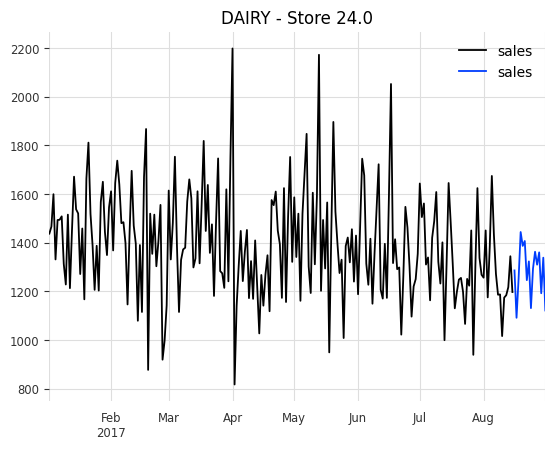

In [67]:
i_series = 23
family = "DAIRY"

make_forecast_plot(
    family=family,
    i_series=i_series,
    dataset=dataset,
    forecast=prediction.reset_index(),
    drop_before_date=pd.Timestamp("2017-01-01"),
)

## Save Submission

In [68]:
save_submission(prediction, "Update_tune_test_LightGBM_EGGS_DAIRY_7_timeshift.csv")

sales    0
dtype: int64
